In [ ]:
# %%

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot, boxcox

In [ ]:
# %%

# Load the dataset
data = pd.read_csv('data/solar_232215.csv', delimiter=',', decimal='.')
# Since we are working with raw data, delete the modified1, modified2, and modified3 columns
data.drop(['modified1', 'modified2', 'modified3'],
          axis=1, inplace=True, errors='ignore')
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)
data

,raw,temperature
timestamp,,
2021-02-02 00:00:00,0.0,-3.9
2021-02-02 01:00:00,0.0,-3.5
2021-02-02 02:00:00,0.0,-3.0
2021-02-02 03:00:00,0.0,-2.6
2021-02-02 04:00:00,0.0,-2.4
...,...,...
2023-02-01 19:00:00,0.0,0.0
2023-02-01 20:00:00,0.0,0.1
2023-02-01 21:00:00,0.0,0.1


In [ ]:
# %%

# Data Description
data_description = data.describe()
data_description

,raw,temperature
count,17016.000000,17016.000000
mean,36912.094888,6.609191
std,66907.410347,9.292033
min,0.000000,-24.500000
25%,0.000000,-0.200000
50%,0.000000,6.400000
75%,38258.015000,13.400000
max,301630.010000,30.100000


<Figure size 1400x600 with 0 Axes>

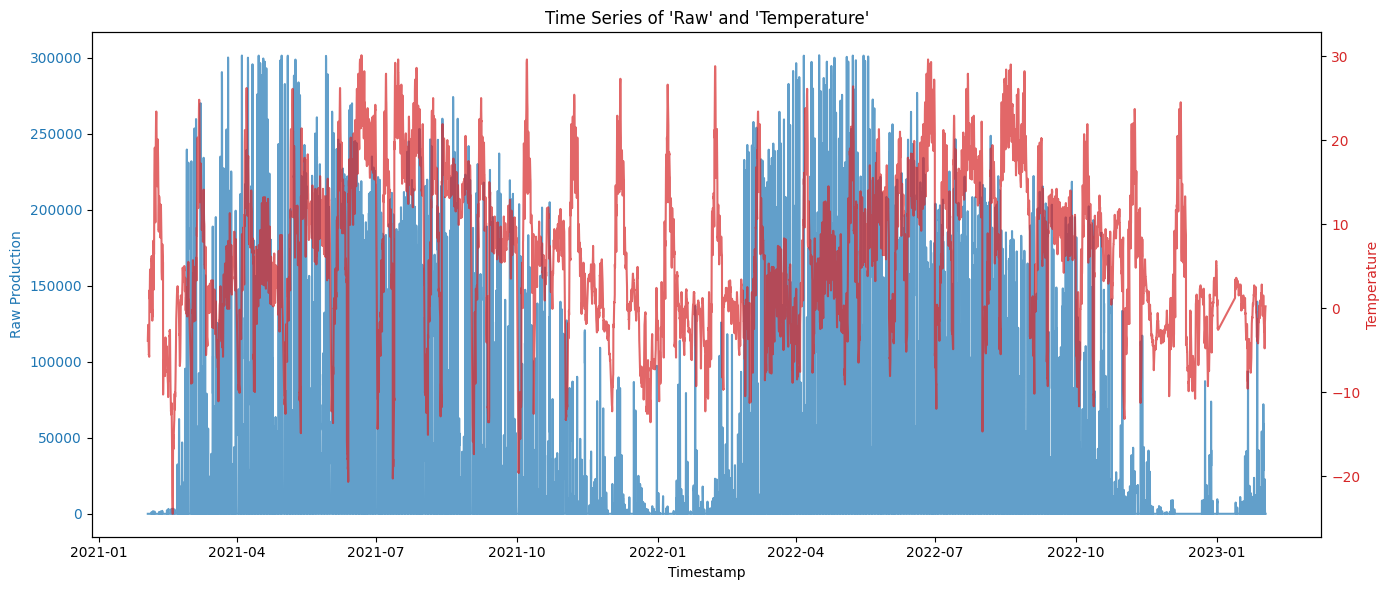

In [ ]:
# %%

# Time Series Plot with Dual Y-Axes
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot for "raw" with primary y-axis
ax1.plot(data.index, data['raw'], label='Raw', color='tab:blue', alpha=0.7)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Raw Production", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis for "temperature"
ax2 = ax1.twinx()
ax2.plot(data.index, data['temperature'],
         label='Temperature', color='tab:red', alpha=0.7)
ax2.set_ylabel("Temperature", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Time Series of 'Raw' and 'Temperature'")
fig.tight_layout()
plt.show()

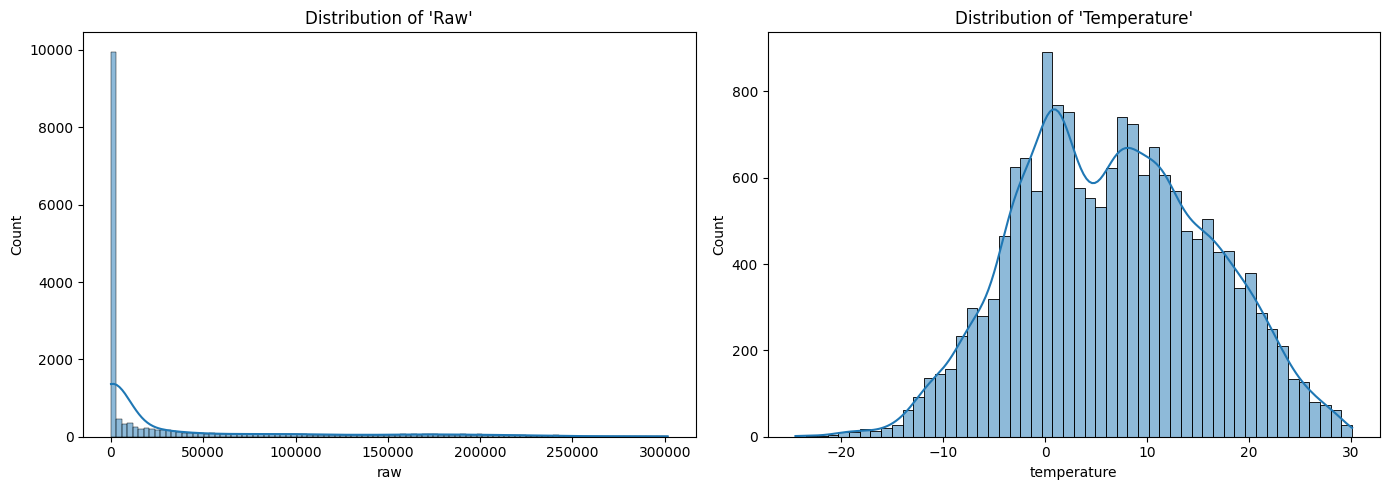

In [ ]:
# %%

# Histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(data['raw'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of 'Raw'")
sns.histplot(data['temperature'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of 'Temperature'")
plt.tight_layout()
plt.show()

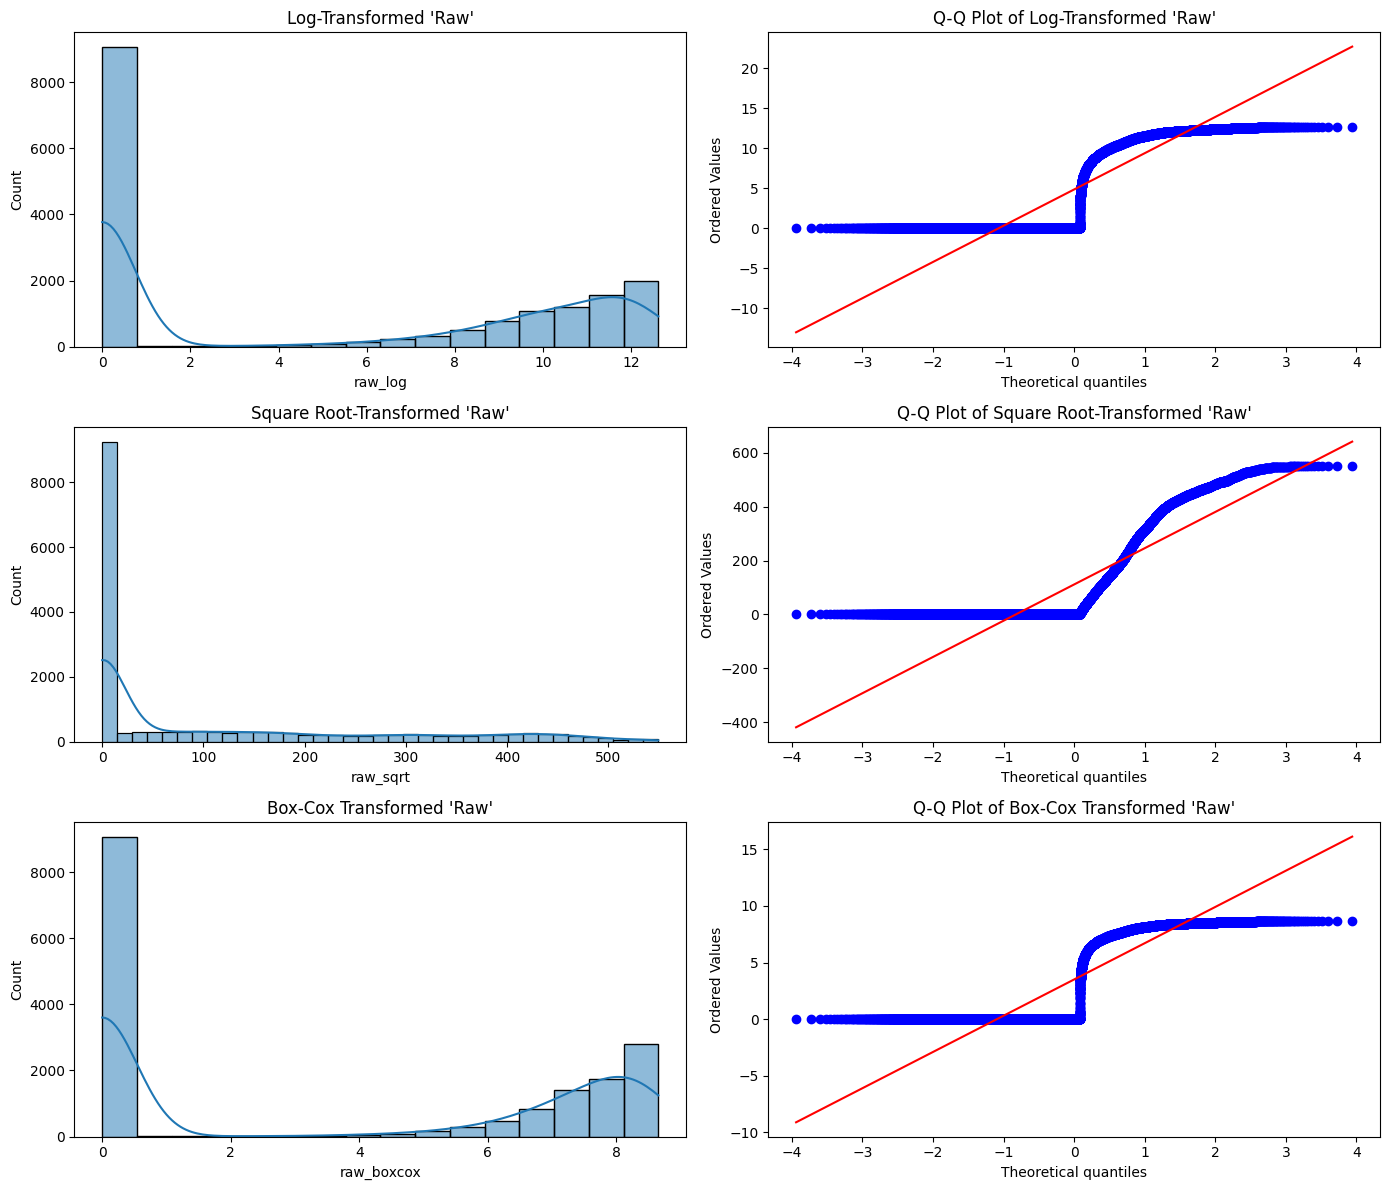

In [ ]:
# %%

# Transformations for "Raw" - Histogram and Q-Q Plot
# Log transformation with small constant for zeros, Square root, and Box-Cox
data['raw_log'] = np.log1p(data['raw'])
data['raw_sqrt'] = np.sqrt(data['raw'])
data['raw_boxcox'], fitted_lambda = boxcox(
    data['raw'] + 1)  # Box-Cox with offset to handle zero

fig, axes = plt.subplots(3, 2, figsize=(14, 12))
sns.histplot(data['raw_log'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Log-Transformed 'Raw'")
probplot(data['raw_log'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title("Q-Q Plot of Log-Transformed 'Raw'")

sns.histplot(data['raw_sqrt'], kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Square Root-Transformed 'Raw'")
probplot(data['raw_sqrt'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title("Q-Q Plot of Square Root-Transformed 'Raw'")

sns.histplot(data['raw_boxcox'], kde=True, ax=axes[2, 0])
axes[2, 0].set_title("Box-Cox Transformed 'Raw'")
probplot(data['raw_boxcox'], dist="norm", plot=axes[2, 1])
axes[2, 1].set_title("Q-Q Plot of Box-Cox Transformed 'Raw'")

plt.tight_layout()
plt.show()

# %% [markdown]

 None of the transformations significantly improved the distribution of 'raw'.

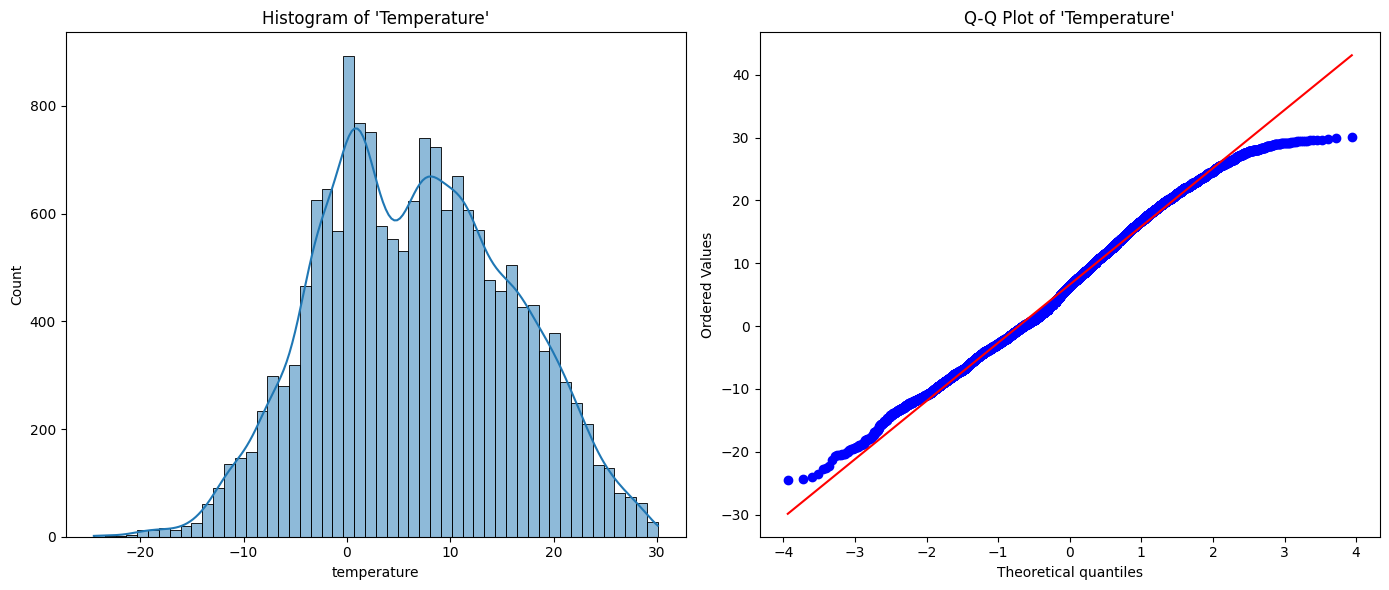

In [ ]:
# %%

# Temperature - Histogram and Q-Q Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(data['temperature'], kde=True, ax=axes[0])
axes[0].set_title("Histogram of 'Temperature'")
probplot(data['temperature'], dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot of 'Temperature'")
plt.tight_layout()
plt.show()

# %% [markdown]

 The temperature distribution is sufficiently symmetric. No transformation is necessary.

In [ ]:
# %%

# Checking for duplicate timestamps
duplicate_timestamps = data.index.duplicated().sum()
duplicate_timestamps

np.int64(0)

# %% [markdown]

 There are no duplicate timestamps in the dataset.

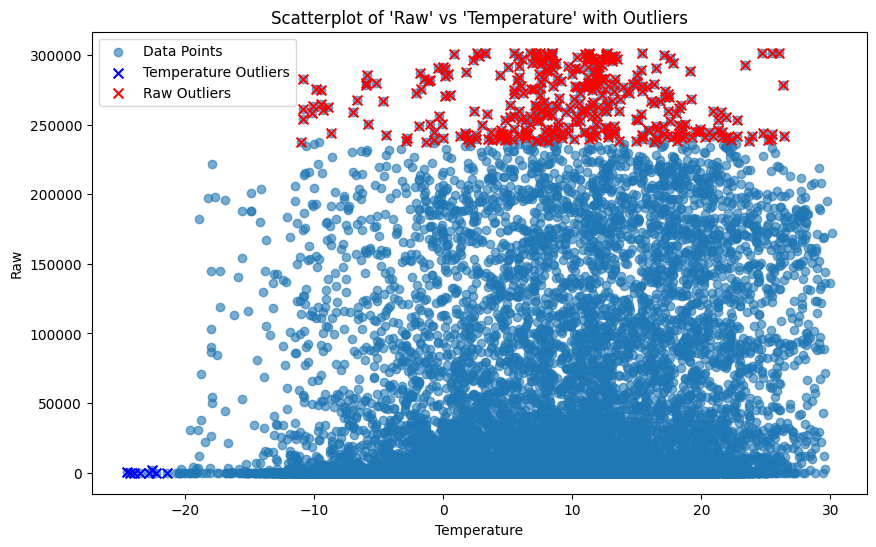

In [ ]:
# %%

# Scatterplot of 'Raw' vs 'Temperature' with Outliers
# Calculating Z-Scores to identify outliers
data['temp_z_score'] = (data['temperature'] -
                        data['temperature'].mean()) / data['temperature'].std()
data['raw_z_score'] = (data['raw'] - data['raw'].mean()) / data['raw'].std()

# Identify points where Z-score exceeds a threshold (e.g., |Z| > 3)
temp_outliers = data[data['temp_z_score'].abs() > 3]
raw_outliers = data[data['raw_z_score'].abs() > 3]

# Plotting the scatterplot with marked outliers
plt.figure(figsize=(10, 6))
plt.scatter(data['temperature'], data['raw'], alpha=0.6, label='Data Points')
plt.scatter(temp_outliers['temperature'], temp_outliers['raw'],
            color='blue', label='Temperature Outliers', s=50, marker='x')
plt.scatter(raw_outliers['temperature'], raw_outliers['raw'],
            color='red', label='Raw Outliers', s=50, marker='x')
plt.title("Scatterplot of 'Raw' vs 'Temperature' with Outliers")
plt.xlabel("Temperature")
plt.ylabel("Raw")
plt.legend()
plt.show()

# %% [markdown]

 There are many outliers somehow. It might make sense to analyze daily averages to identify whether these outliers are consistent across days.

In [ ]:
# %%

daily_data = data.resample('D').mean()
daily_data

,raw,temperature,raw_log,raw_sqrt,raw_boxcox,temp_z_score,raw_z_score
timestamp,,,,,,,
2021-02-02,0.000000,-4.058333,0.000000,0.000000,0.000000,-1.148029,-0.551689
2021-02-03,0.000000,2.075000,0.000000,0.000000,0.000000,-0.487965,-0.551689
2021-02-04,46.591667,2.325000,0.292515,1.393312,0.235579,-0.461061,-0.550993
2021-02-05,263.025833,4.083333,1.854145,8.094186,1.512756,-0.271830,-0.547758
2021-02-06,236.162500,14.275000,1.627236,7.247500,1.323804,0.824987,-0.548159
...,...,...,...,...,...,...,...
2023-01-28,5428.475833,-1.858333,2.941760,37.390964,2.220555,-0.911267,-0.470555
2023-01-29,2687.852500,0.037500,2.782449,26.765828,2.139831,-0.707239,-0.511516
2023-01-30,7023.851667,1.262500,3.106298,42.721414,2.327888,-0.575406,-0.446711


<Figure size 1400x600 with 0 Axes>

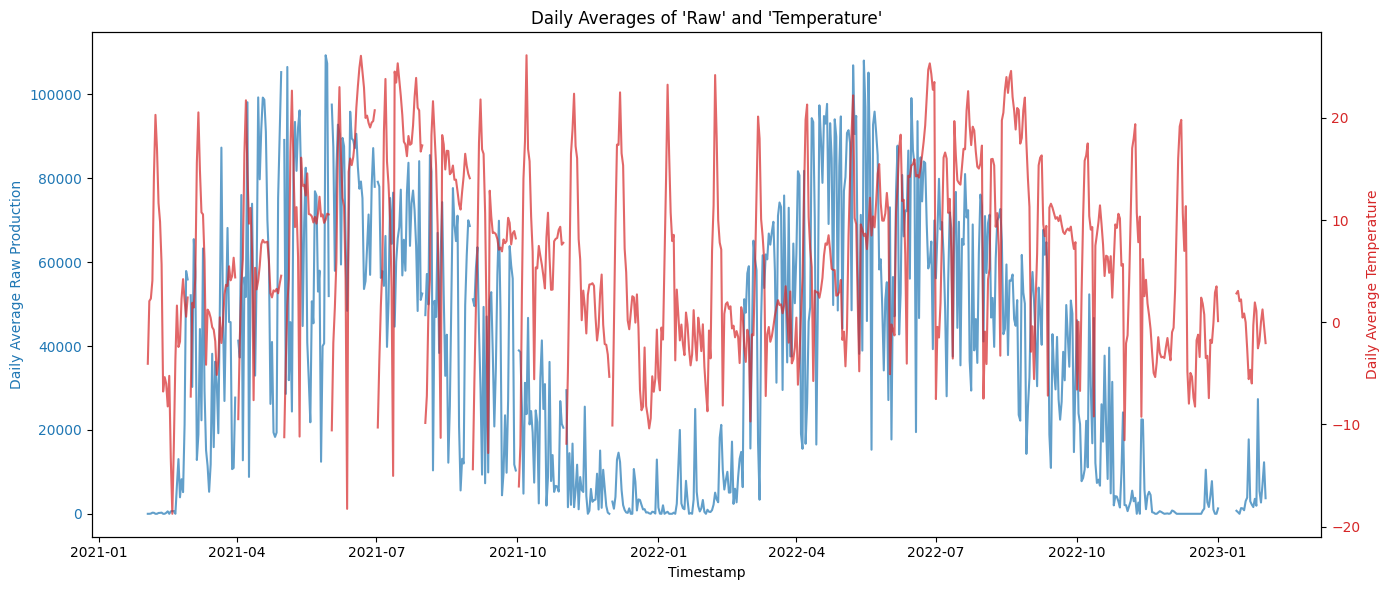

In [ ]:
# %%

# Time Series Plot of Daily Averages with Dual Y-Axes
plt.figure(figsize=(14, 6))
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot for daily average "raw" on the primary y-axis
ax1.plot(daily_data.index,
         daily_data['raw'], label='Daily Average Raw', color='tab:blue', alpha=0.7)
ax1.set_xlabel("Timestamp")
ax1.set_ylabel("Daily Average Raw Production", color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary y-axis for daily average "temperature"
ax2 = ax1.twinx()
ax2.plot(daily_data.index, daily_data['temperature'],
         label='Daily Average Temperature', color='tab:red', alpha=0.7)
ax2.set_ylabel("Daily Average Temperature", color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Daily Averages of 'Raw' and 'Temperature'")
fig.tight_layout()
plt.show()

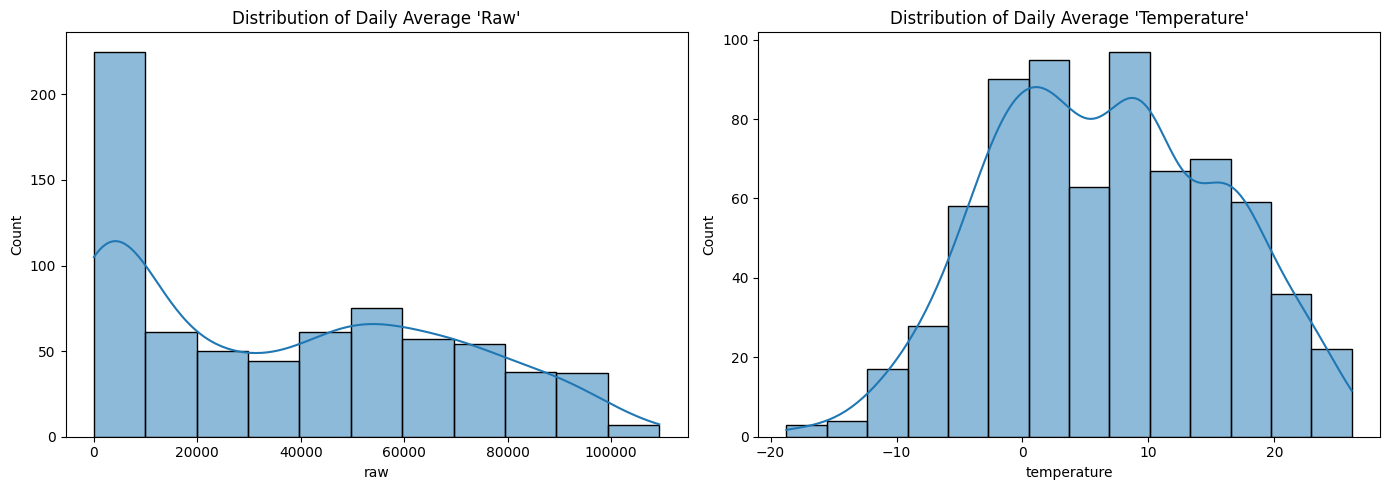

In [ ]:
# %%

# Histograms of Daily Averages
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.histplot(daily_data['raw'], kde=True, ax=axes[0])
axes[0].set_title("Distribution of Daily Average 'Raw'")
sns.histplot(daily_data['temperature'], kde=True, ax=axes[1])
axes[1].set_title("Distribution of Daily Average 'Temperature'")
plt.tight_layout()
plt.show()

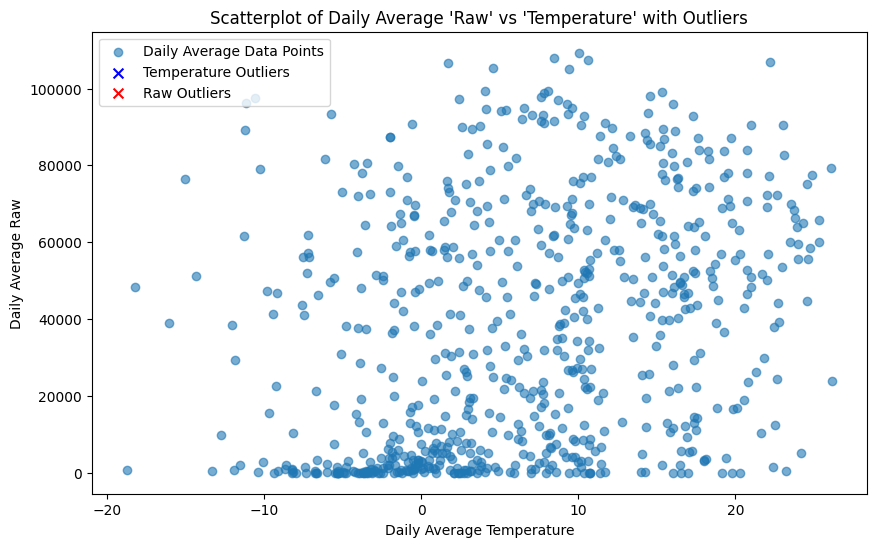

In [ ]:
# %%

# Outlier Detection for Daily Data
# Z-score method on daily data with threshold of 3 standard deviations
daily_data['temp_z_score'] = (daily_data['temperature'] -
                              daily_data['temperature'].mean()) / daily_data['temperature'].std()
daily_data['raw_z_score'] = (
    daily_data['raw'] - daily_data['raw'].mean()) / daily_data['raw'].std()

# Identifying outliers in daily data
daily_temp_outliers = daily_data[daily_data['temp_z_score'].abs() > 3]
daily_raw_outliers = daily_data[daily_data['raw_z_score'].abs() > 3]

# Scatterplot of Daily Average 'Raw' vs 'Temperature' with Outliers
plt.figure(figsize=(10, 6))
plt.scatter(daily_data['temperature'], daily_data['raw'],
            label='Daily Average Data Points', alpha=0.6)
plt.scatter(daily_temp_outliers['temperature'], daily_temp_outliers['raw'],
            color='blue', label='Temperature Outliers', s=50, marker='x')
plt.scatter(daily_raw_outliers['temperature'], daily_raw_outliers['raw'],
            color='red', label='Raw Outliers', s=50, marker='x')
plt.title("Scatterplot of Daily Average 'Raw' vs 'Temperature' with Outliers")
plt.xlabel("Daily Average Temperature")
plt.ylabel("Daily Average Raw")
plt.legend()
plt.show()

# %% [markdown]

 Analyzing daily trends and averages showed better picture for outlier detection but did not reveal significant patterns or transformations
 (besides obvious seasonal pattern for such data) that would further improve data normalization.